In [1]:
!pip install torch torchvision opencv-python

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

Number of people detected: 5


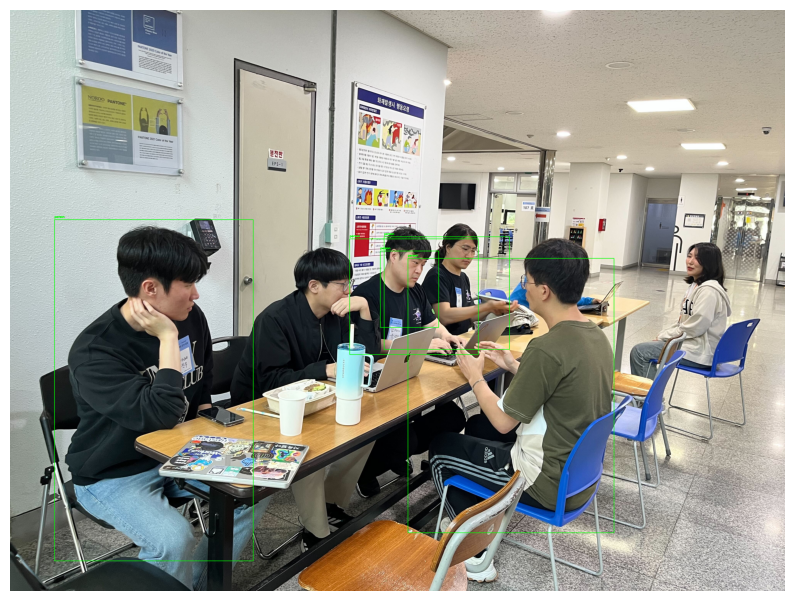

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# YOLOv3-tiny 모델과 구성 파일, 가중치 파일, 클래스 이름 파일 경로
cfg_path = "yolov3-tiny.cfg"
weights_path = "yolov3-tiny.weights"
names_path = "coco.names"

# COCO 클래스 이름 로드
try:
    with open(names_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]
except Exception as e:
    print(f"Error loading class names: {e}")

# 네트워크 설정
try:
    net = cv2.dnn.readNet(weights_path, cfg_path)
except Exception as e:
    print(f"Error loading model: {e}")

# GPU 사용 여부 설정 (선택 사항)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# 객체 탐지를 위한 설정
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# 이미지 전처리
def preprocess_image(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            print("Error: Image not found.")
            return None, None
        blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
        return image, blob
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None, None

def get_detections(blob):
    try:
        net.setInput(blob)
        outs = net.forward(output_layers)
        return outs
    except Exception as e:
        print(f"Error during detection: {e}")
        return None

def count_people(image_path):
    image, blob = preprocess_image(image_path)
    if image is None or blob is None:
        return
    height, width, channels = image.shape
    outs = get_detections(blob)
    if outs is None:
        return

    class_ids = []
    confidences = []
    boxes = []
    person_count = 0

    # 탐지 결과 해석
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5 and classes[class_id] == "person":
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                person_count += 1

    # 사람의 수 출력
    print(f"Number of people detected: {person_count}")

    # 결과 이미지 출력 (matplotlib 사용)
    for i in range(len(boxes)):
        if class_ids[i] == 0:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = (0, 255, 0)
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # 이미지 채널을 BGR에서 RGB로 변환
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# 이미지에서 사람 감지 및 수 세기
image_path = '/content/sample2.png'  # 생성된 이미지 경로로 설정
count_people(image_path)
